# **Desafio: Crie um modelo de análise das métricas RFV**

Você deverá utilizar um modelo de Clustering para criar um sistema de agrupamento de perfis de clientes para um e-commerce. Deverá analisar o modelo mais eficiente, capaz de tornar as análises mais simplificadas para a empresa.


## **Contexto**

Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de
marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo
dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.
Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em
comum entre os clientes, como:
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

**Sobre os dados**

Os dados estão disponíveis no [Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data). Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

<center>

| Coluna | Descrição | Tipo |
| ----------- | ----------- | ----------- |
| *InvoiceNo* | Identificação da transação | Int |
| *StockCode* | Código de estoque do produto | String |
| *Description* |  Descrição do produto | String |
| *Quantity* | Quantidade de produtos por transação | Int |
| *InvoiceDate* | Data da transação | Datetime |
| *UnitPrice* | Preço unitário do produto | Float |
| *CustomerID* | Identificação do cliente | Int |
| *Country* | País de origem da transação | String |

</center>

## **Análise Exploratória dos Dados**

### Setup

In [92]:
# Import das bibliotecas
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from yellowbrick.cluster import kelbow_visualizer

In [31]:
# Tema dos gráficos
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

### Dataset

In [53]:
# Criação do dataframe
df = pd.read_csv("https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fe73c934e-cd3a-4e00-85f6-b704762fec77%2Fdata.csv?table=block&id=e9f1a77d-e0db-46c4-8ef0-c79064da3c0e&spaceId=6a055055-52ec-4ebb-a697-63027c951344&userId=c0845f00-59fb-4a0f-bb4a-c1e2314cd202&cache=v2", encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [33]:
# Verificação dos tipos de dados e valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Verificamos a existência de valores nulos e de colunas com formatos incorretos que serão tratados posteriormente.

In [34]:
# Descrição estatística dos dados numéricos
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Verificamos a existência de valores negativos e um desvio padrão bastante grande, que serão tratados posteriormente.

In [35]:
# Verificação de valores faltantes por coluna
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [36]:
# Verificação de linhas duplicadas
df.duplicated().sum()

5268

Verificamos a existência de linhas duplicadas que serão tratadas posteriormente.

### Análise Univariada

#### InvoiceNo


In [37]:
df['InvoiceNo'].sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

Os dados estão no formato `object` pela existência de valores alfanuméricos.

In [38]:
df['InvoiceNo'].nunique()

25900

Foram feitas 25900 transações distintas.

#### StockCode

In [39]:
df['StockCode'].nunique()

4070

Existem 4070 códigos de estoque distintos.

#### Description

In [40]:
df['Description'].nunique()

4223

Existem 4223 produtos distintos.

#### Quantity

<Axes: >

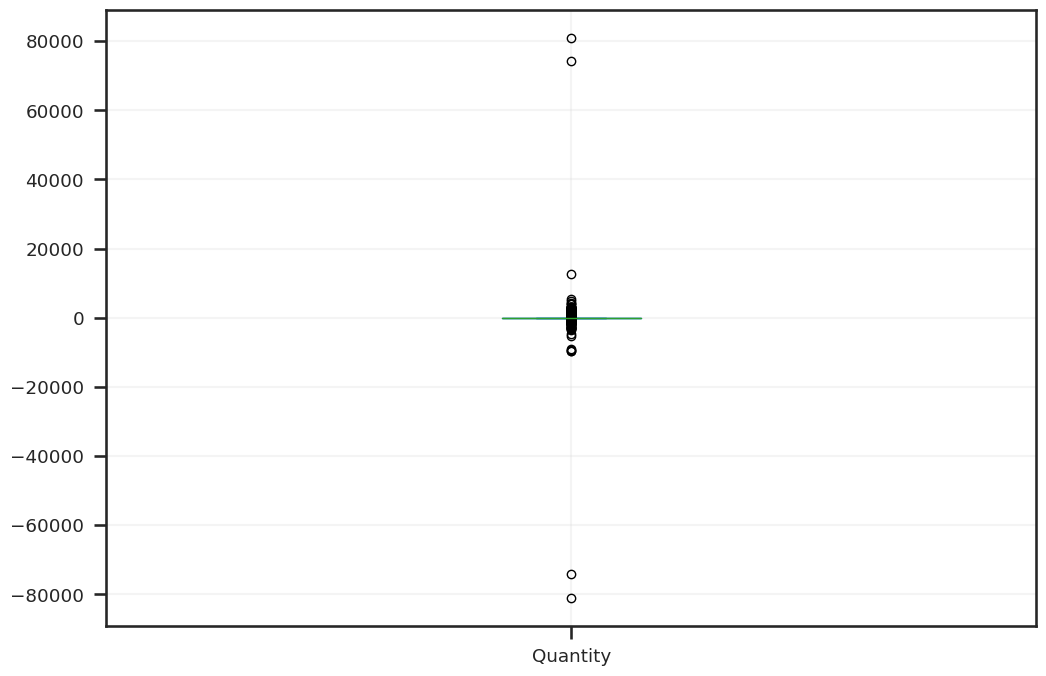

In [42]:
df['Quantity'].plot.box();

Verificamos a existência de valores negativos de quantidade que serão tratados posteriormente, assim como a existência de alguns outliers.

#### UnitPrice

<Axes: >

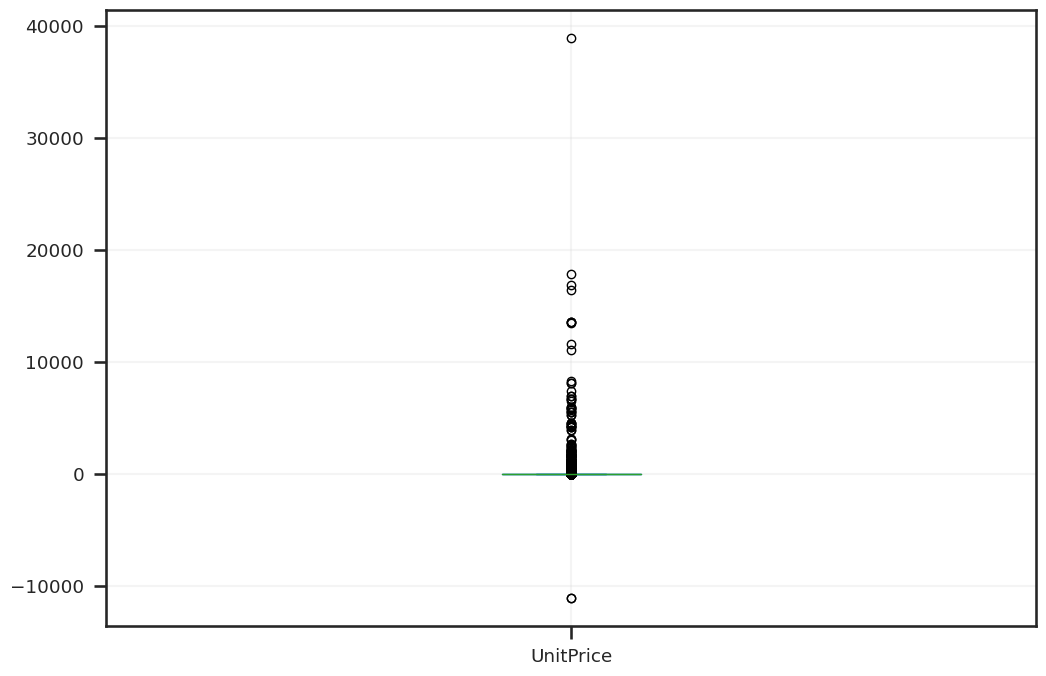

In [43]:
df['UnitPrice'].plot.box();

Verificamos a existência de produtos com preço negativo que serão tratados posteriormente.

#### CustomerID

In [44]:
df['CustomerID'].nunique()

4372

Existem 4372 clientes distintos.

#### Country

In [49]:
df['Country'].value_counts(ascending=False)

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


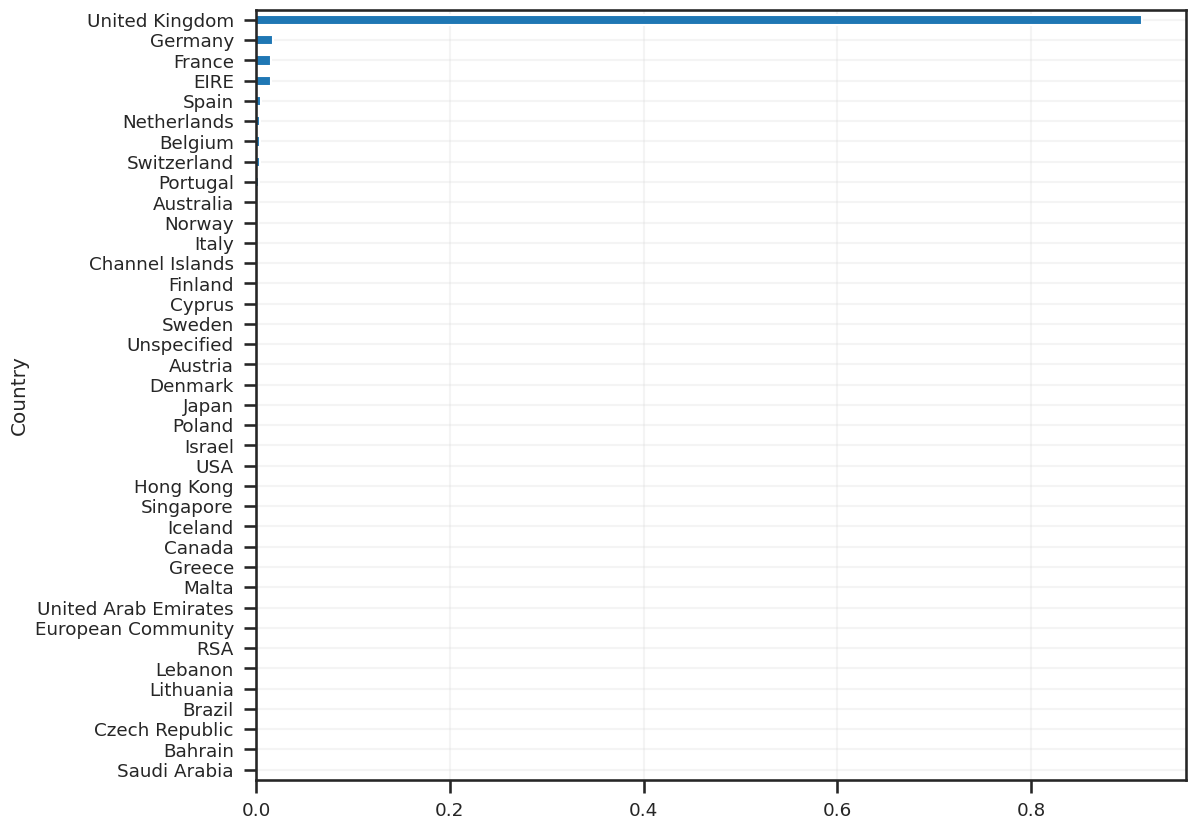

In [46]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10));

Verificamos que o Reino Unido é responsável pela grande maioria das transações.

## Pré-processamento dos dados

### Data Cleaning

In [56]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()
df.duplicated().sum()

0

In [57]:
# Remoção de linhas nulas
df = df.dropna(subset=['CustomerID'])
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [62]:
# Correção dos tipos de variáveis
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country              category
dtype: object

In [64]:
# Remoção dos valores negativos das colunas Quantity e UnitPrice
negativos = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~negativos].copy()

<Axes: >

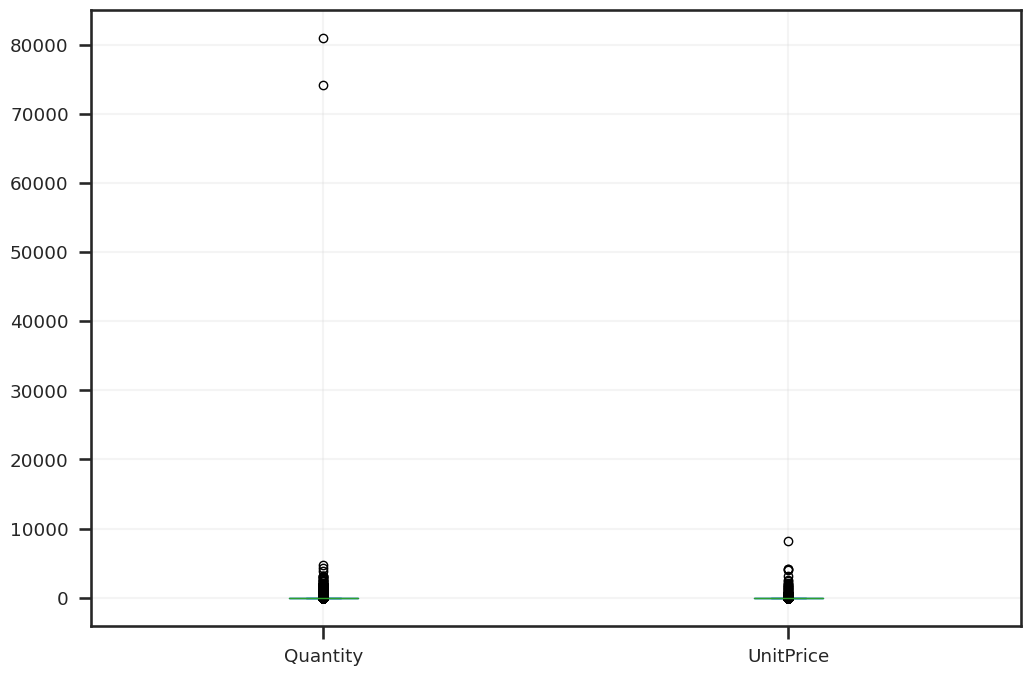

In [65]:
# Visualização do plot box com os valores corretos
df[['Quantity','UnitPrice']].plot.box();

Verificamos a existência de 2 outliers bastante significativos na coluna Quantity.

<Axes: >

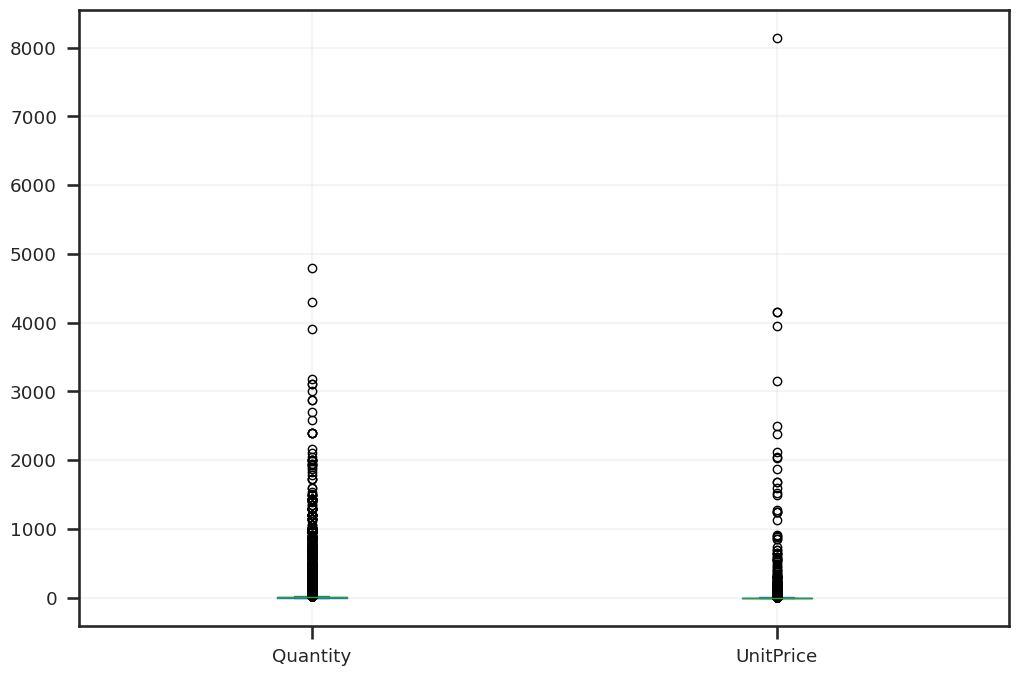

In [67]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

Removendo os 2 outliers, verificamos a existência de 1 outlier bastante significativo na coluna UnitPrice.

In [68]:
# Remoção dos outliers
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

### Criação das variáveis RFM

In [70]:
# Criação de coluna com o preço total da compra
df['TotalPrice'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [71]:
# Criação da referência temporal
df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

Como os dados referem-se ao período de 2010 a 2011, vamos adotar a data do início de 2012 como referência.

In [72]:
pd.Timestamp('2012-01-01')

Timestamp('2012-01-01 00:00:00')

In [76]:
# Criação do dataframe RFM
rfm = df.groupby('CustomerID').agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('TotalPrice', 'mean')
  )

rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


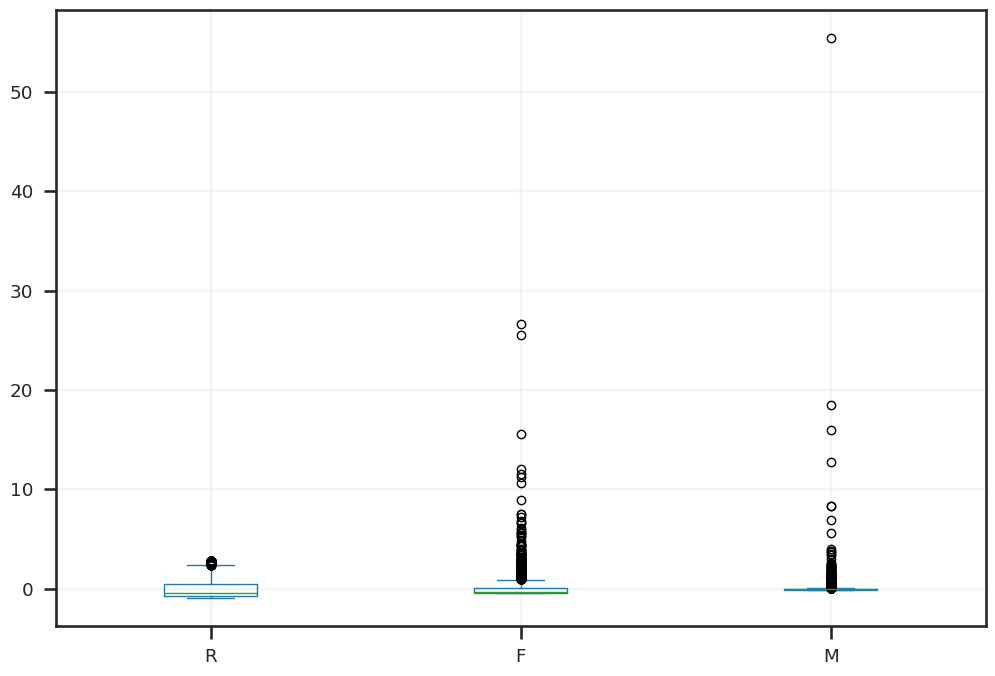

In [78]:
# Visualização do plot box RFM
rfm.apply(scale).plot.box();

Verificamos a existência de 1 outlier significativo em M.

In [80]:
# Remoção do outlier
rfm = rfm.drop(15098)

In [84]:
# Transformação dos dados
scaler = PowerTransformer()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm), index=rfm.index, columns=rfm.columns)
rfm_scaled.head()

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407173
12348,0.323470,0.660670,1.331122
12349,-0.809134,-1.158070,0.426251
12350,1.568467,-1.158070,0.187636
12352,-0.307718,1.309671,0.653747


<Axes: >

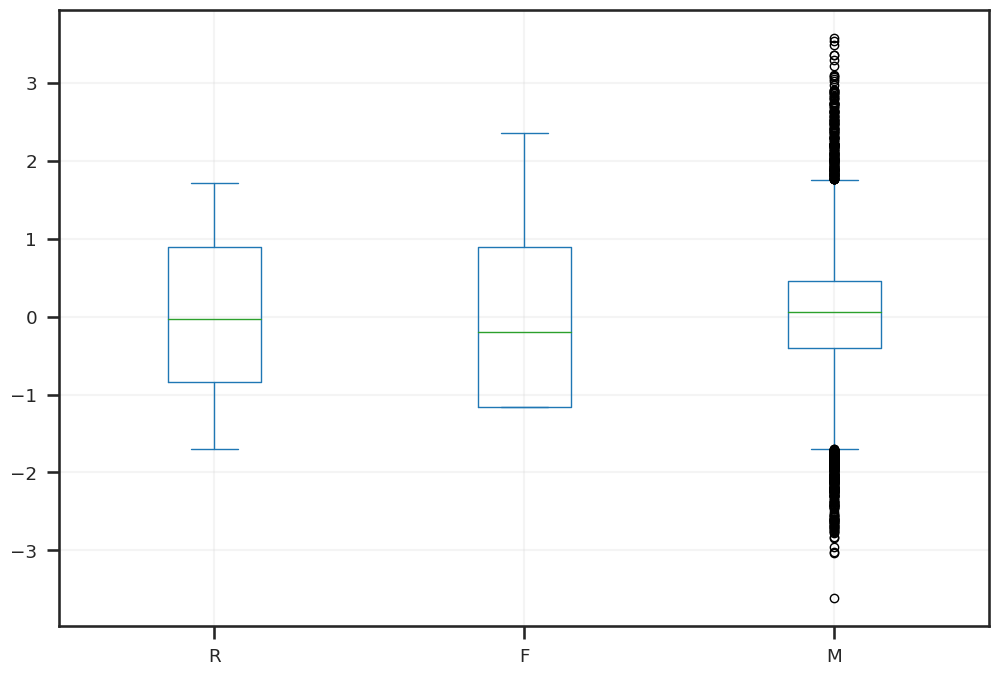

In [85]:
# Plot box RFM transformado
rfm_scaled.plot.box();

In [86]:
# Descrição estatística dos dados transformados
rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.585253
std,99.968352,7.697927,129.203857
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,395.000000,209.000000,4453.430000


Verificamos a existência de outliers acima de 3 desvios padrão. Para atenuar sua influência, vamos utilizar o método `clip`, que limita os valores fora do padrão para o limite dos valores. Nesta caso, vamos utilizar como limitante o valor do percentil 95.   

In [87]:
rfm_clip = rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.662082
std,95.504576,3.358999,20.978901
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.737784
75%,163.250000,5.000000,24.853250
max,333.000000,13.000000,91.768421


In [88]:
# Normalização dos dados
rfm_clip_scaled = rfm_clip.apply(scale)

## Algoritmo de clusterização

Para o problema em questão, optou-se por utilizar o algoritmo **KMeans**, por conta de sua simplicidade, eficiência e facilidade de implementação. Além disso, os dados foram tratados de maneira a otimizar o algoritmo, uma vez que ele não lida muito bem com outliers.

### Número de clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

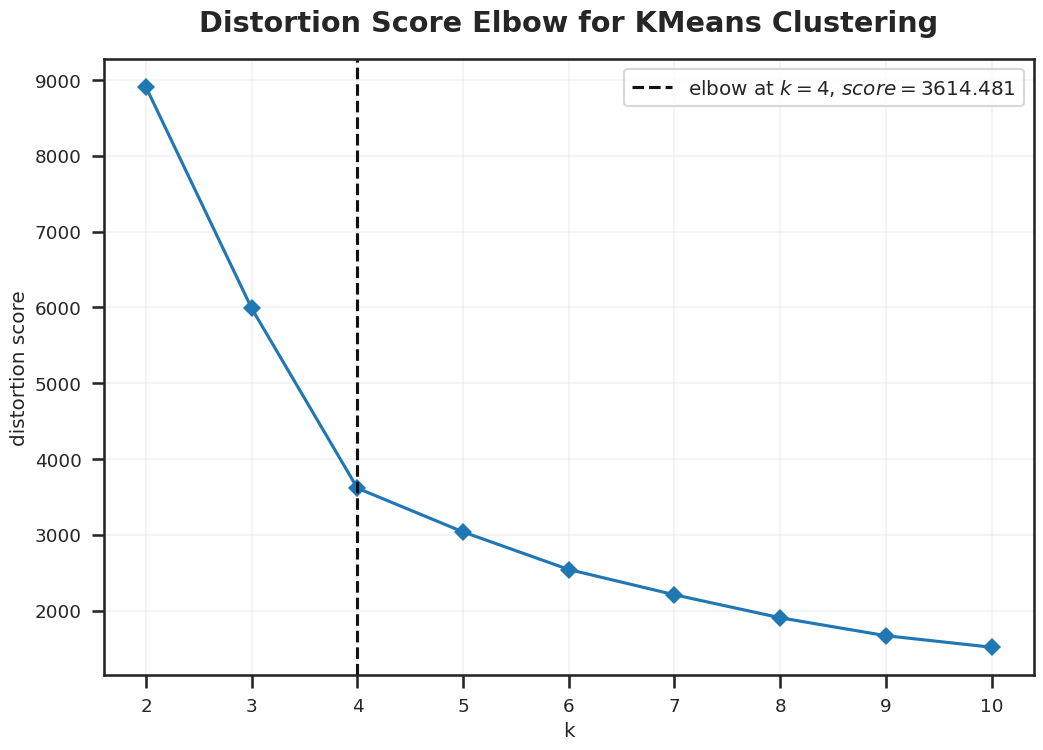

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [89]:
# Método do cotovelo
kelbow_visualizer(KMeans(), rfm_clip_scaled, k=10, timings=False)

In [90]:
# Criação de métricas
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8906.742887,0.382383,1.065382,1995.684047
3,5986.625769,0.434294,0.858641,2540.965121
4,3614.488857,0.479660,0.704316,3752.748844
5,3037.063238,0.485026,0.737517,3554.760285
6,2541.205884,0.398243,0.851045,3566.913817
7,2207.904692,0.377034,0.869849,3529.273069
8,1905.807285,0.383798,0.861791,3601.863562
9,1667.753068,0.394185,0.800766,3677.796298
10,1515.506507,0.351802,0.887664,3645.024627


Com base nos métodos de Elbow e Silhouette Score, utilizaremos como número de cluster o valor 4.

In [91]:
# Criação e predição do modelo
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Análise dos clusters

In [93]:
# Visualização 3D dos clusters
px.scatter_3d(rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

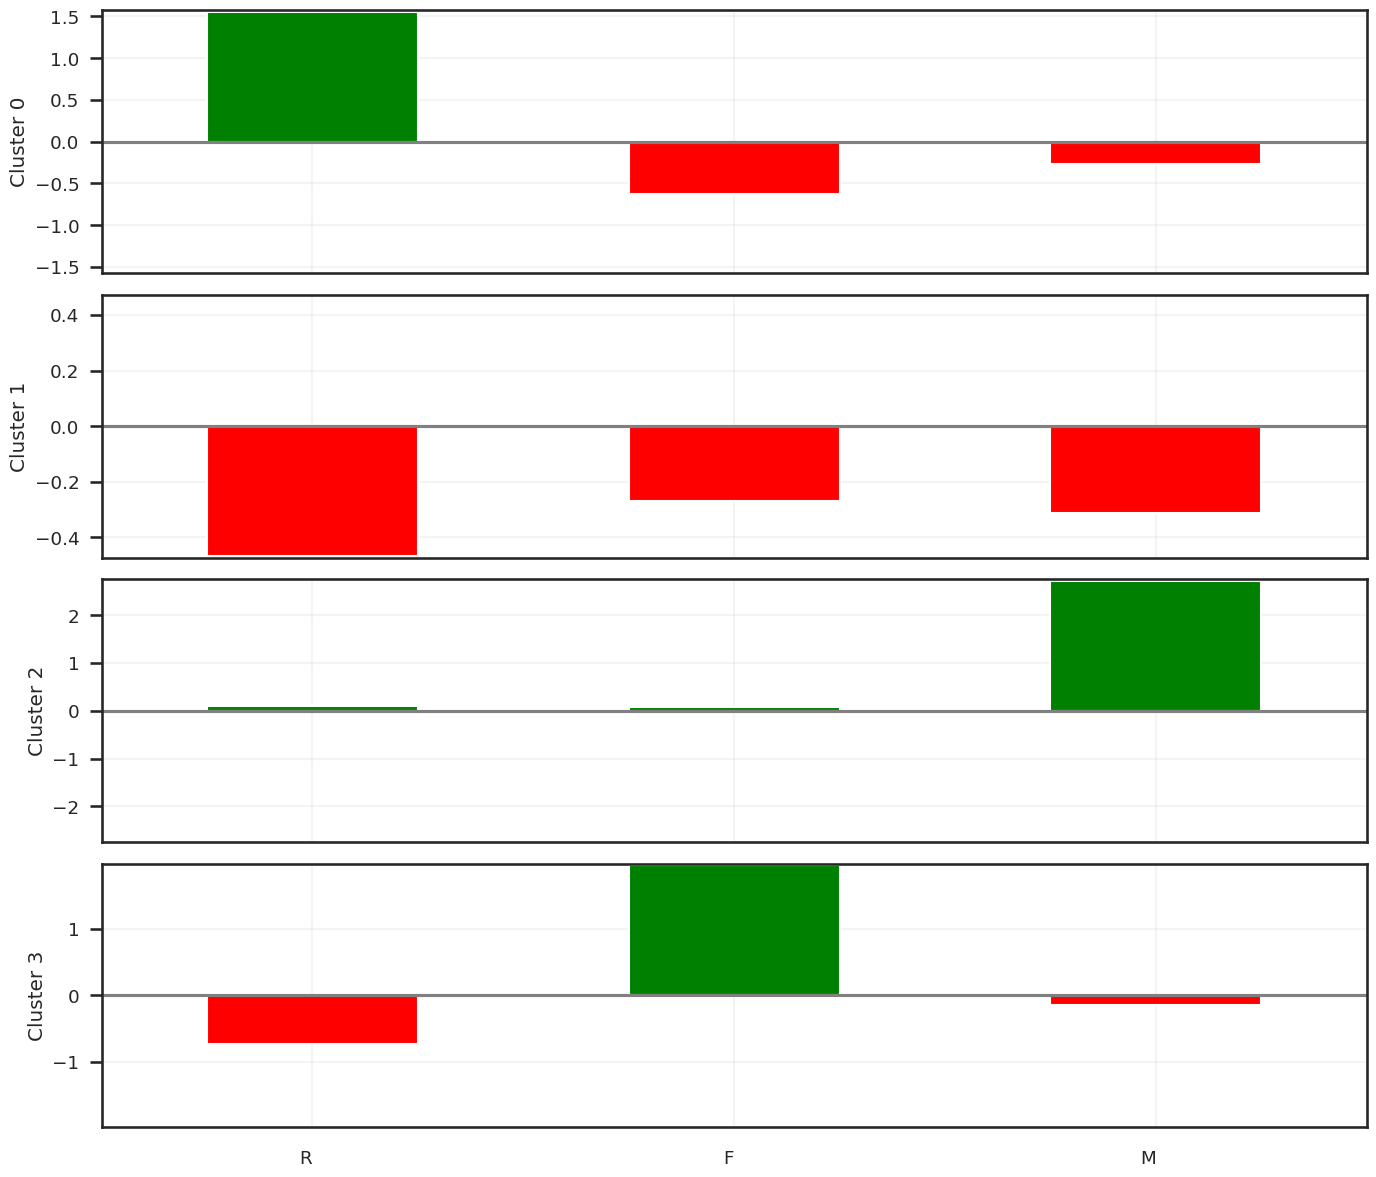

In [102]:
# Comparação entre os centroides dos clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_clip_scaled.columns)

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [97]:
# Visuzalição matricial dos clusters
rfm_clip.assign(cluster=kmeans_labels).groupby('cluster').mean().transpose().style.background_gradient(cmap='YlOrRd', axis=1)

cluster,0,1,2,3
R,261.082051,67.523221,121.057935,41.517018
F,1.509744,2.703877,3.876574,10.191248
M,18.121764,17.153676,80.710870,20.467061


## Interpretação dos clusters

Conforme visto nos gráficos e figuras apresentados na seção Análise dos Clusters, podemos identificar como características de cada cluster:

<center>

| Cluster | Recência | Frequência | Monetary |
| ----------- | ----------- | ----------- | ----------- |
| 0 | Alta | Baixa | Baixa-Média
| 1 | Baixa | Baixa | Baixa-Média
| 2 | Variável | Variável | Alta
| 3 | Baixa | Alta | Baixa-Média

</center>

A partir disso, podemos definir o perfil de cada cliente.

- Os clientes que se enquadram no **cluster 0** tem grande chance de serem **churn**, uma vez que a recência deles é alta, ou seja, a última compra foi feita há bastante tempo;
- Os clientes que se enquadram no **cluster 1** são provavelmente **clientes novos**, considerando que o volume de compras é baixo, mas são compras mais recentes;
- Os clientes que se enquadram no **cluster 2** são os **clientes mais gastadores**, que fazem compras com um ticket médio alto, podendo ser clientes frequentes ou não;
- Os clientes que se enquadram no **cluster 3** são os **clientes mais fiéis**, que fazem um número alto de compras e de maneira regular.

Esta análise pode ser extremamente útil para a empresa, pois por meio da segmentação de clientes é possível entender melhor o perfil de cada tipo de cliente. Uma potencial aplicação desta segmentação é para personalização de campanhas de marketing mais direcionadas ou para recomendação de determinados tipos de produtos, trazendo mais retorno para o empresa.

Por exemplo, para os clientes do cluster 0 poderiam ser enviados emails para lembrar das compras feitas no e-commerce, pedindo avaliações ou até então oferecendo cupons de desconto para o retorno do cliente à plataforma. Para os clientes do cluster 1, poderiam ser feitas recomendações de produtos similares ou complementares aos comprados recentemente. Para os clientes do cluster 2, poderiam ser feitas recomendações de produtos mais caros. Para os clientes do cluster 3, a comunicação não precisa ser feita de maneira tão agressiva, uma vez que os clientes já estão mais fidelizados.

Estas são apenas alguns exemplos da aplicação da segmentação de clientes, existem ainda muitos outros com bastante potencial de geração de valor para o negócio.